# Sparse sampling

$$
\newcommand{\wmax}{{\omega_\mathrm{max}}}
\newcommand{\dd}{{\mathrm{d}}}
\newcommand{\ii}{{\mathrm{i}}}
\newcommand{\iv}{{\mathrm{i}\nu}}
\newcommand{\tauk}{{\bar{\tau}_k}}
\newcommand{\wk}{{\bar{\omega}^\alpha_k}}
\newcommand{\vk}{{\bar{\nu}_k}}
\newcommand{\hatFmat}{\hat{\mathbf{F}}}
\newcommand{\Fmat}{{\mathbf{F}}}
$$

We consider how to compute the $L$ expansion coefficients of a Green's function in IR from its numerical values known on a finite set of imaginary times or imaginary frequencies.
The idea of the sparse sampling is simple.
If we want to determine $L$ coefficients $G_l$,
we need to know $G(\tau)$ on only up to $L$ sampling points.
Let $\bar{\tau}_1 < \cdots < \bar{\tau}_{N_\mathrm{smp}}$ ($N_\mathrm{smpl}\ge L$) be such sampling points,
one can evaluate the expansion coefficients as

$$
\begin{align}
    g_l &= \underset{g_l}{\mathrm{argmin}}
        \sum_k \bigg| G(\tauk) - \sum_{l=0}^{N_\mathrm{smp}-1} U_l(\tauk)G_l \bigg|^2\nonumber \\
    &= (\Fmat^+ \boldsymbol{g})_l,
\end{align}
$$

where we define $(\Fmat)_{kl} = U_l(\tauk)$ and $\Fmat^+$ is its pseudo inverse.
The numerical stability of this ``fitting'' scheme is determined
by the condition number of the coefficient matrix $\Fmat$.
An empiritically good choice is to use the middle points of the extrema of 
$U'_{L-1}(\tau)$.
From experience, the fitting can be done in the most stable way using SVD of the fitting matrix (already implemented in *sparse-ir*).

The following figure shows the sampling points in the imaginary-time domain generated for $\beta=10$ and $\wmax=10$ as well as the basis function $U_{L-1}(\tau)$ with $L=30$.

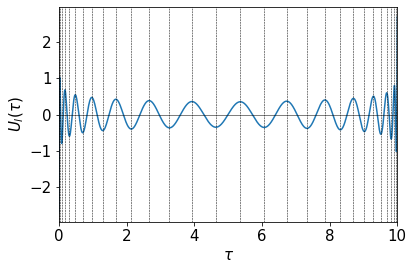

In [1]:
import sparse_ir
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

beta = 10
wmax = 10
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=1e-10)

smpl = sparse_ir.TauSampling(basis)

taus = np.linspace(0, beta, 1000)
plt.plot(taus, basis.u[-1](taus))
plt.plot(taus, np.zeros_like(taus), ls='-', color='k', marker='', lw=0.5)
for x in smpl.sampling_points:
    plt.axvline(x=x, ls='--', lw=0.5, color='k')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$U_l(\tau)$')
plt.xlim([0, beta])
plt.tight_layout()

One can transform numerical data in the Matsubara-frequency domain using sparse-sampling techniques {cite}`Li:2020eu`.
The IR basis functions $\hat U_l(\iv)$ are purely imaginary/real for even/odd $l$.
Although the basis functions $U_l(\iv)$ are defined only on discrete points,
the respective parts have sign structures similarly to those of $U_l(\tau)$.
The figure shown below shows the basis functions for the largest $l$ 
as well as the corresponding sampling frequencies.
A sign change generally takes place between two adjacent Matsubara frequencies.
A segment between two adjacent "roots" contains at least one sampling points.
In the upper panel, you can see that the last segment at high frequencies contains two sampling points.
This improves the condition number slighly.

Let $\bar{\nu}_1 < \cdots < \bar{\nu}_{N_\mathrm{smp}}$ ($N_\mathrm{smpl}\ge L$)
be such sampling frequencies,
one can evaluate the expansion coefficients as

$$
\begin{align}
    g_l &= \underset{g_l}{\mathrm{argmin}}
        \sum_k \bigg| \hat G(\ii\vk) - \sum_{l=0}^{N_\mathrm{smp}-1} \hat{U}_l(\ii\vk)G_l \bigg|^2\nonumber \\
    &= (\hat{\Fmat}^+ \boldsymbol{g})_l.
\end{align}
$$

The following figure shows the sampling points in the imaginary-frequency domain generated for $\beta=10$ and $\wmax=10$.

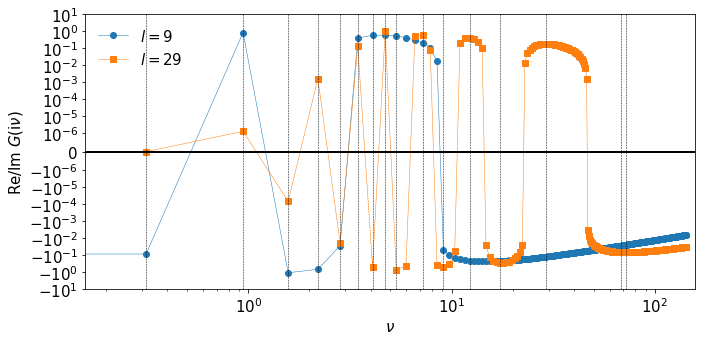

In [2]:
smpl_matsu = sparse_ir.MatsubaraSampling(basis)

get_nonzero_part = lambda l, data: data.imag if l%2==0 else data.real 

fig, ax = plt.subplots(figsize=(10,5))

nmax = int(2*(smpl_matsu.sampling_points.max()//2))
nvec = 2*np.arange(-nmax,nmax)+1
vvec = nvec * np.pi/beta
markers = ["o", "s"]
for idx_l, l in enumerate([9, basis.size-1]):
    ax.plot(vvec, get_nonzero_part(l, basis.uhat[l](nvec)), 
        label=f"$l={l}$", ls="-", marker=markers[idx_l], ms=6, lw=0.5)

for n in smpl_matsu.sampling_points:
    ax.axvline(n*np.pi/beta, ls="--", lw=0.5, color="k")
    ax.axhline(0, ls="-", lw=0.25, color="k")

ax.legend(frameon=False)
ax.set_xlabel(r"$\nu$")
ax.set_ylabel(r"Re/Im $G(\mathrm{i}\nu)$")

ax.set_xlim([0.5*np.pi/beta, None])
ax.set_ylim([-10, 10])
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1e-6)

plt.tight_layout()

## Condition number
The condition number of the fitting scales roughly as $\sqrt{\Lambda}$.

In [3]:
cond_tau = []
cond_matsu = []
lambdas = [1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
for lambda_ in lambdas:
    basis = sparse_ir.FiniteTempBasis("F", beta, lambda_/beta, eps=1e-15)
    cond_tau.append(sparse_ir.TauSampling(basis).cond)
    cond_matsu.append(sparse_ir.MatsubaraSampling(basis).cond)

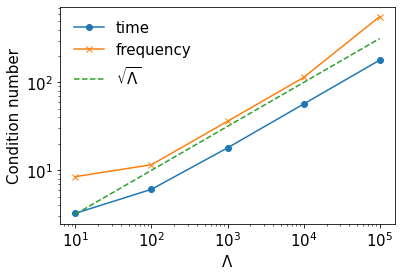

In [4]:
plt.loglog(lambdas, cond_tau, marker="o", label="time")
plt.loglog(lambdas, cond_matsu, marker="x", label="frequency")
plt.loglog(lambdas, np.sqrt(lambdas), marker="", ls="--", label=r"$\sqrt{\Lambda}$")
plt.xlabel(r"$\Lambda$")
plt.ylabel("Condition number")
plt.legend(frameon=False)
plt.show()